In [1]:
# bayes classifier over emotion dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from lib.dataset_utils import *
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
from lib.plot_utils import plot_multilabel_confusion_heatmap, plot_score_barplot, get_scores_dict, custom_classification_report
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import string
import pickle
import os
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
DATASET = DatasetEnum.GoEmotionsCleaned
# load dataset
train_df, val_df, test_df = load_dataset(DATASET)
LABELS = train_df.columns[1:]
TEXT_COLUMN = 'text'

In [3]:
def OVA_clf_analysis(train_df, val_df, classifier, text_col, label_cols):
    # train classifier
    classifier.fit(train_df[text_col], train_df[label_cols])
    # predict
    predictions_train = classifier.predict(train_df[text_col])
    predictions_val = classifier.predict(val_df[text_col])
    # convert to dataframe
    predictions_train = pd.DataFrame(predictions_train, columns=label_cols)
    predictions_val = pd.DataFrame(predictions_val, columns=label_cols)
    # calculate metrics
    print("Train metrics")
    scores_dict = get_scores_dict(predictions_train, train_df, label_cols)
    custom_classification_report(scores_dict, label_cols)
    print("Val metrics")
    scores_dict = get_scores_dict(predictions_val, val_df, label_cols)
    custom_classification_report(scores_dict, label_cols)
    # plot confusion matrix
    print("Train confusion matrix")
    plot_multilabel_confusion_heatmap(train_df[label_cols].to_numpy(), predictions_train.values, label_cols, label_cols, normalize=True)
    print("Val confusion matrix")
    plot_multilabel_confusion_heatmap(val_df[label_cols].to_numpy(), predictions_val.values, label_cols, label_cols, normalize=True)
    # bar plot over classes
    plot_score_barplot(train_df[label_cols], predictions_train, label_cols)
    plot_score_barplot(val_df[label_cols], predictions_val, label_cols)

In [4]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def clean_content(text):
    # tokenize
    clean_text = nltk.word_tokenize(text)
    
    # pos tag
    clean_text = nltk.pos_tag(clean_text)
    TAG_MAP = {'N': 'n', 'V': 'v', 'R': 'r', 'J': 'a'}
    clean_text = [(word, TAG_MAP.get(tag[0], 'n')) for word, tag in clean_text]

    # lemmatize
    clean_text = [lemmatizer.lemmatize(word, tag) for word, tag in clean_text]

    # remove punctuation marks
    clean_text = [w for w in clean_text if w not in string.punctuation]

    return ' '.join(clean_text)

def clean_df(df, text_col, out_col):
    df[out_col] = df[text_col].apply(clean_content)
    return df

In [5]:
CLEAN_TEXT_COLUMN = 'clean_text'
train_df = clean_df(train_df, TEXT_COLUMN, CLEAN_TEXT_COLUMN)
val_df = clean_df(val_df, TEXT_COLUMN, CLEAN_TEXT_COLUMN)
test_df = clean_df(test_df, TEXT_COLUMN, CLEAN_TEXT_COLUMN)

# TFIDF Decision tree

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          1.00                1.00                1.00                0.99                4130
amusement                           1.00                1.00                1.00                0.99                2328
disapproval                         1.00                0.99                1.00                0.99                2022
disgust                             1.00                0.99                1.00                0.99                 793
embarrassment                       1.00                1.00                1.00                1.00                 303
excitement                          1.00                0.96                0.98                0.96                 853
fear                                1.00                0.99                1.00                0.99                

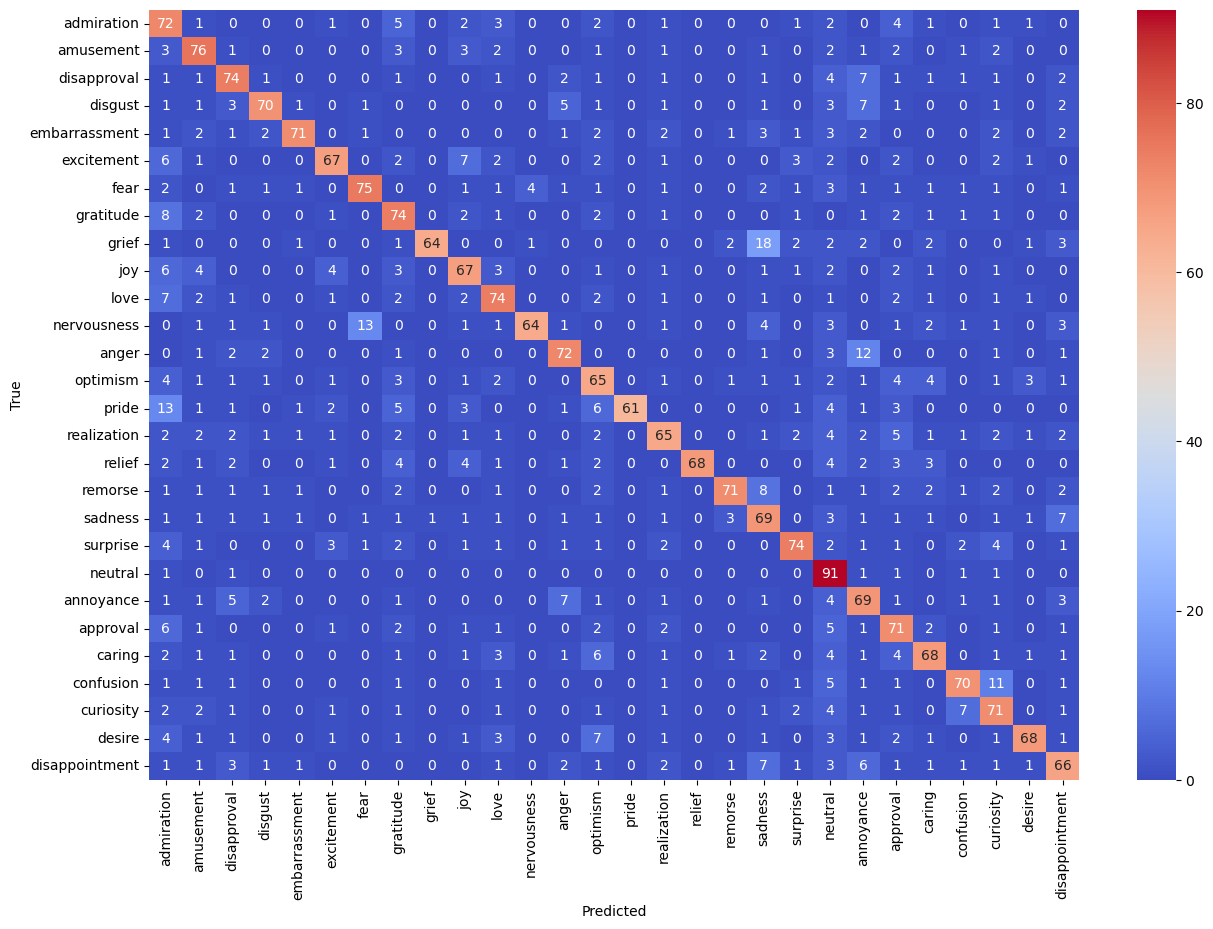

Val confusion matrix


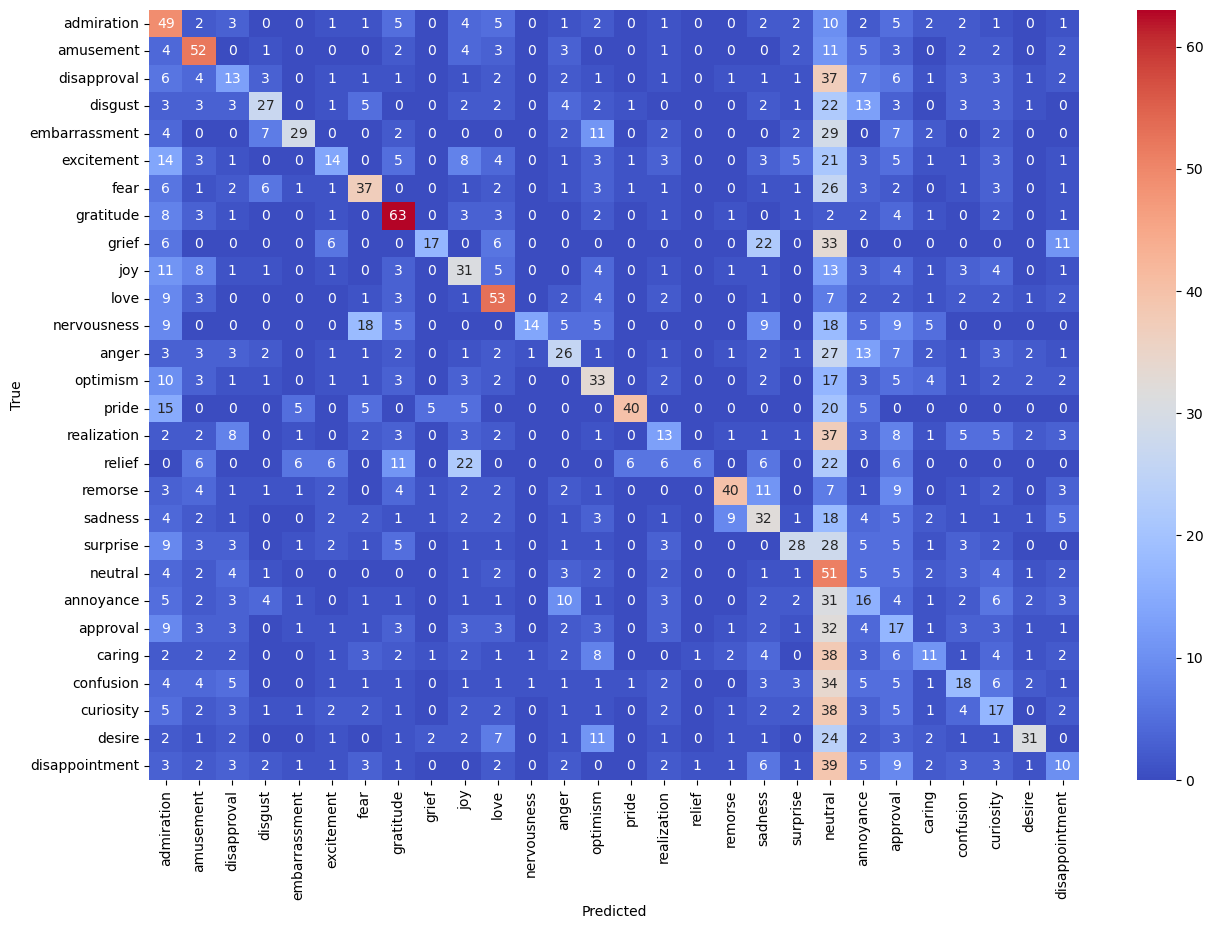

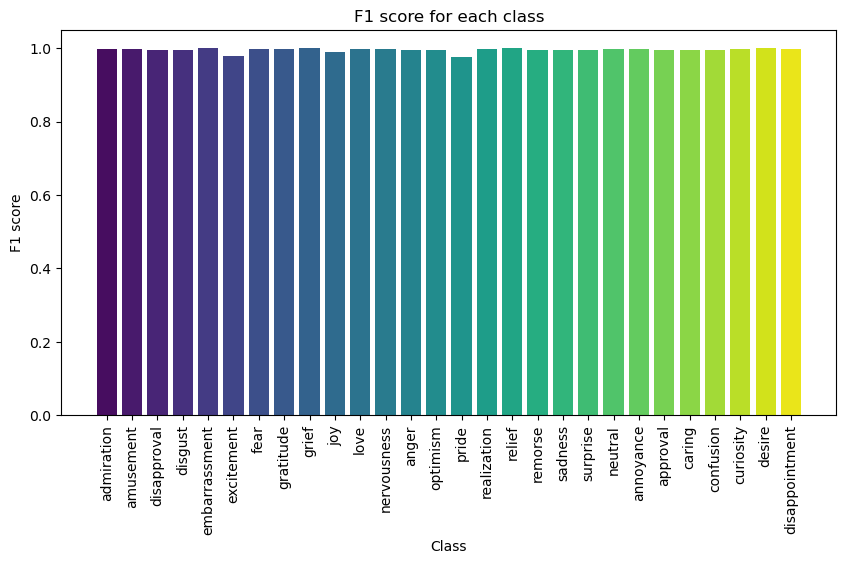

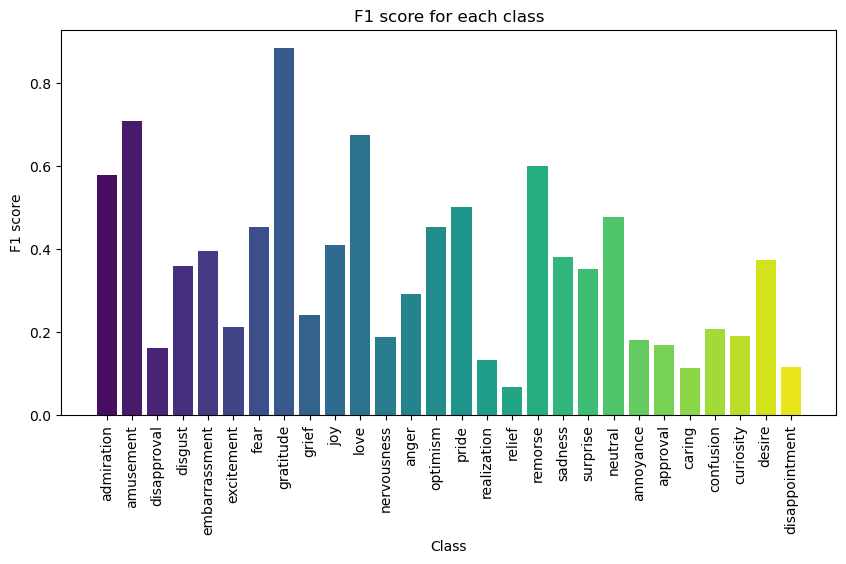

In [6]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier())
]))

OVA_clf_analysis(train_df, val_df, classifier, TEXT_COLUMN, LABELS)

with cleaning

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          1.00                0.99                1.00                0.99                4130
amusement                           1.00                1.00                1.00                0.99                2328
disapproval                         1.00                1.00                1.00                0.99                2022
disgust                             1.00                0.99                1.00                0.99                 793
embarrassment                       1.00                1.00                1.00                1.00                 303
excitement                          1.00                0.95                0.98                0.95                 853
fear                                1.00                0.99                1.00                0.99                

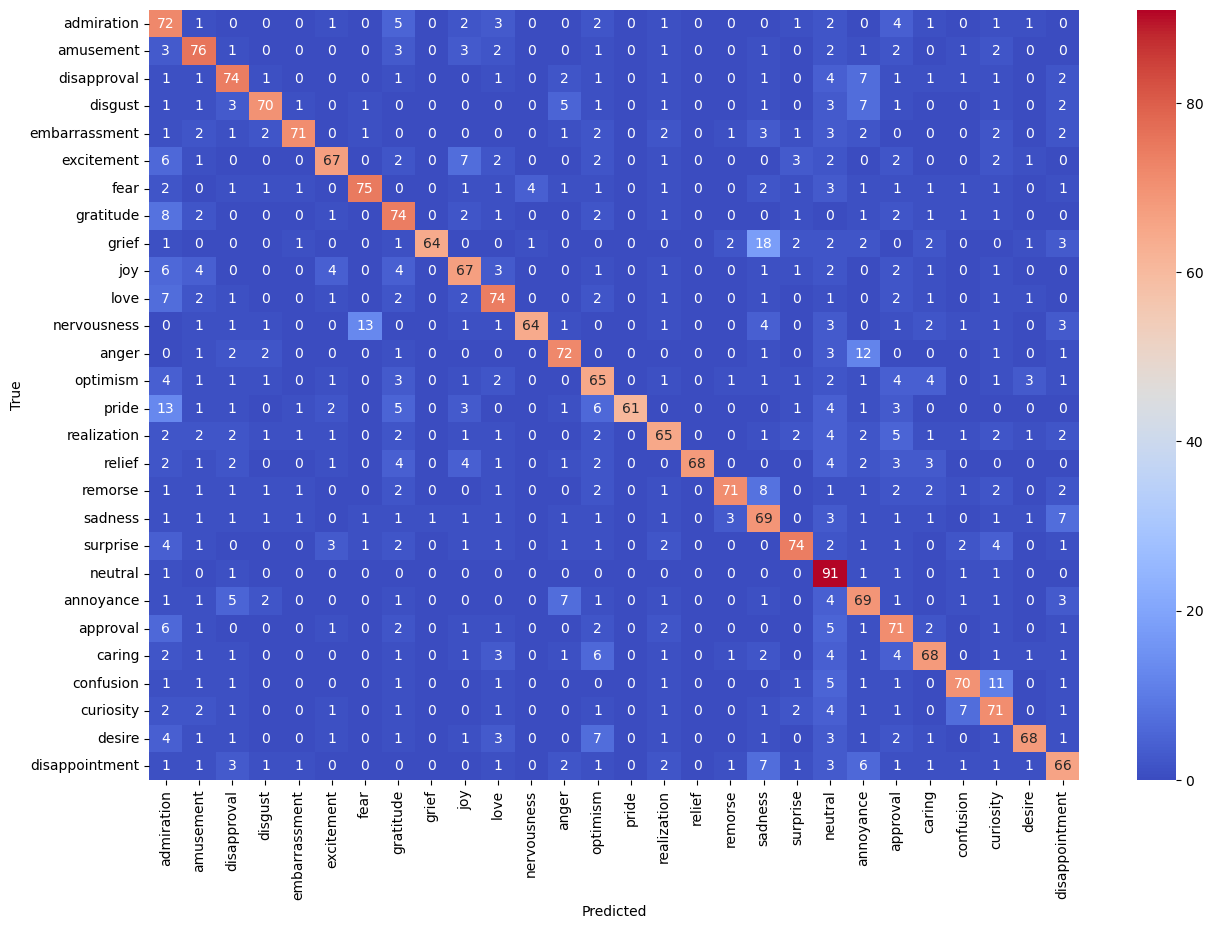

Val confusion matrix


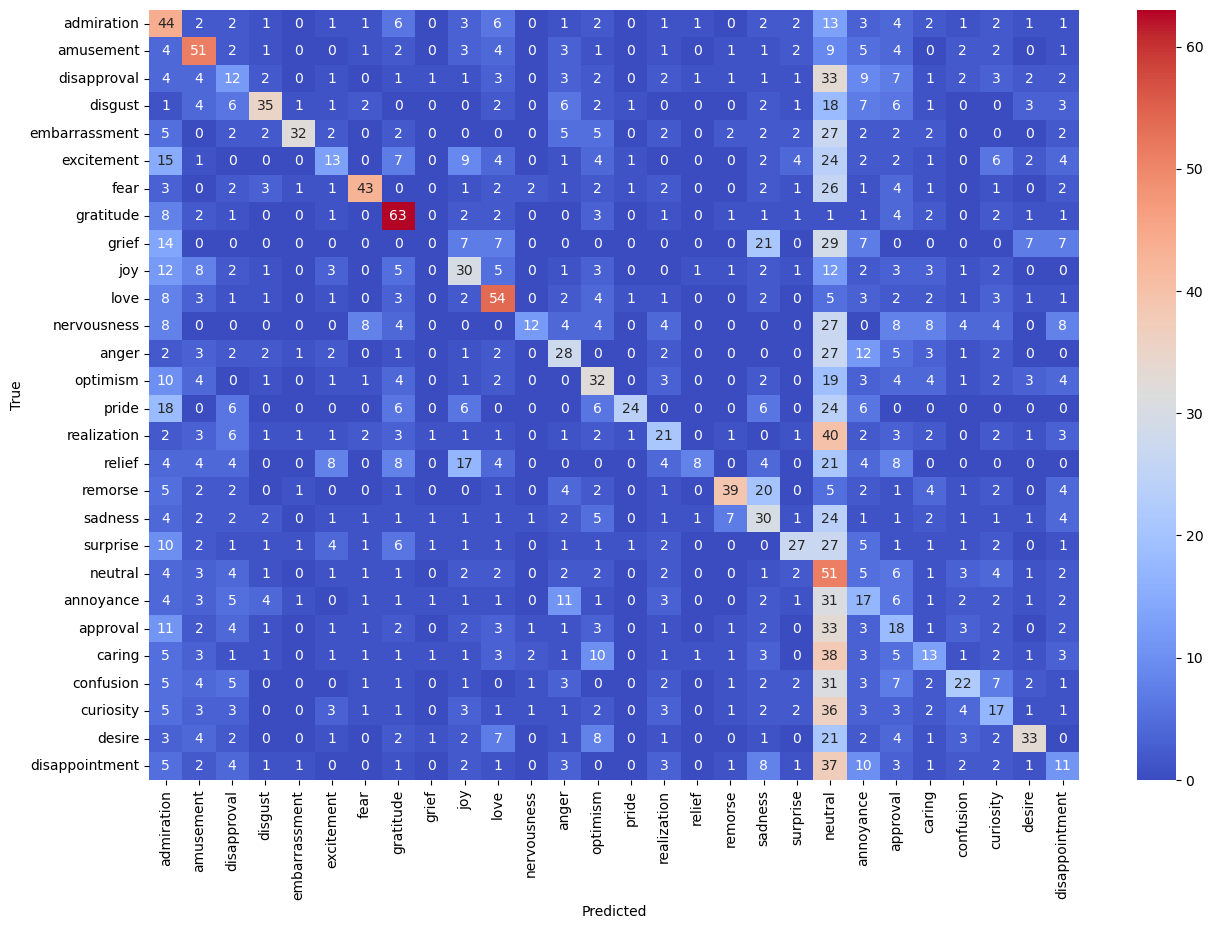

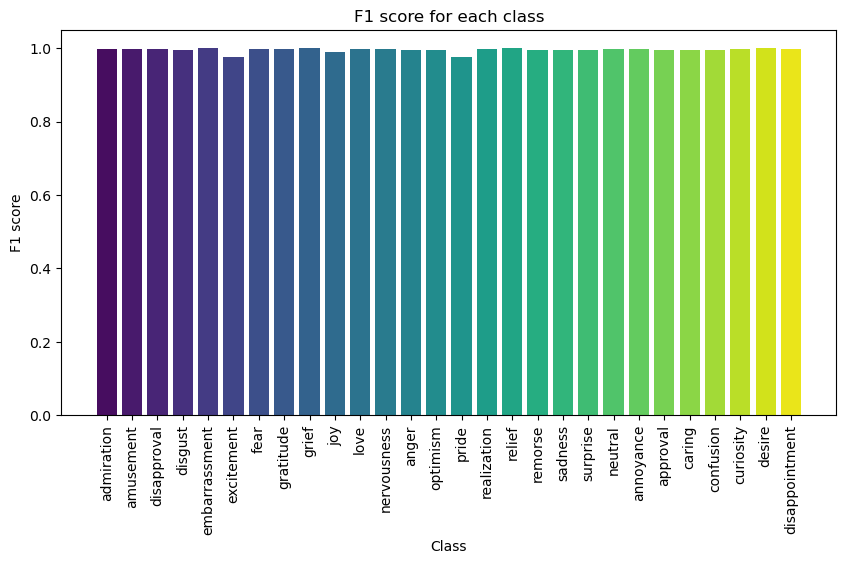

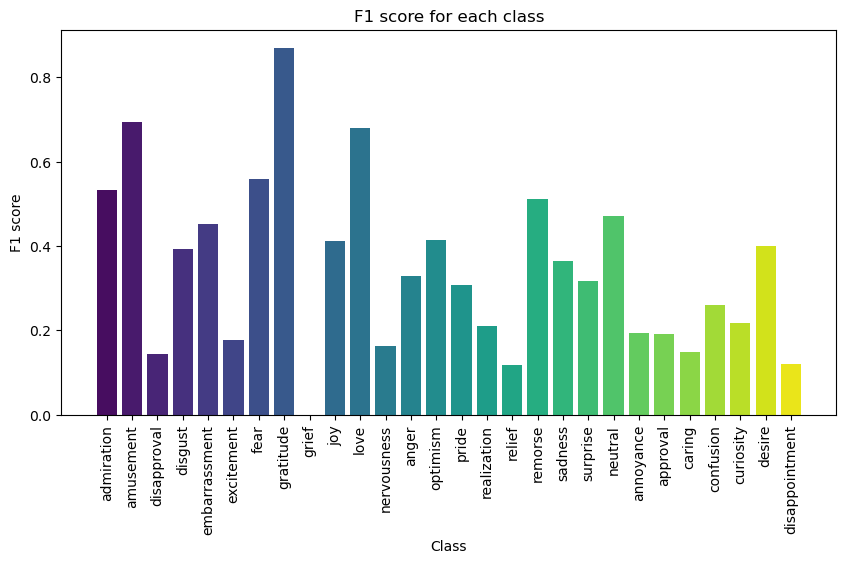

In [7]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier())
]))

OVA_clf_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

low gain from cleaned data

### Feature selection

Attempt with min df

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          1.00                0.99                0.99                0.99                4130
amusement                           1.00                0.99                1.00                0.99                2328
disapproval                         1.00                0.99                1.00                0.99                2022
disgust                             1.00                0.99                0.99                0.99                 793
embarrassment                       1.00                0.99                1.00                0.99                 303
excitement                          1.00                0.93                0.96                0.93                 853
fear                                1.00                0.98                0.99                0.98                

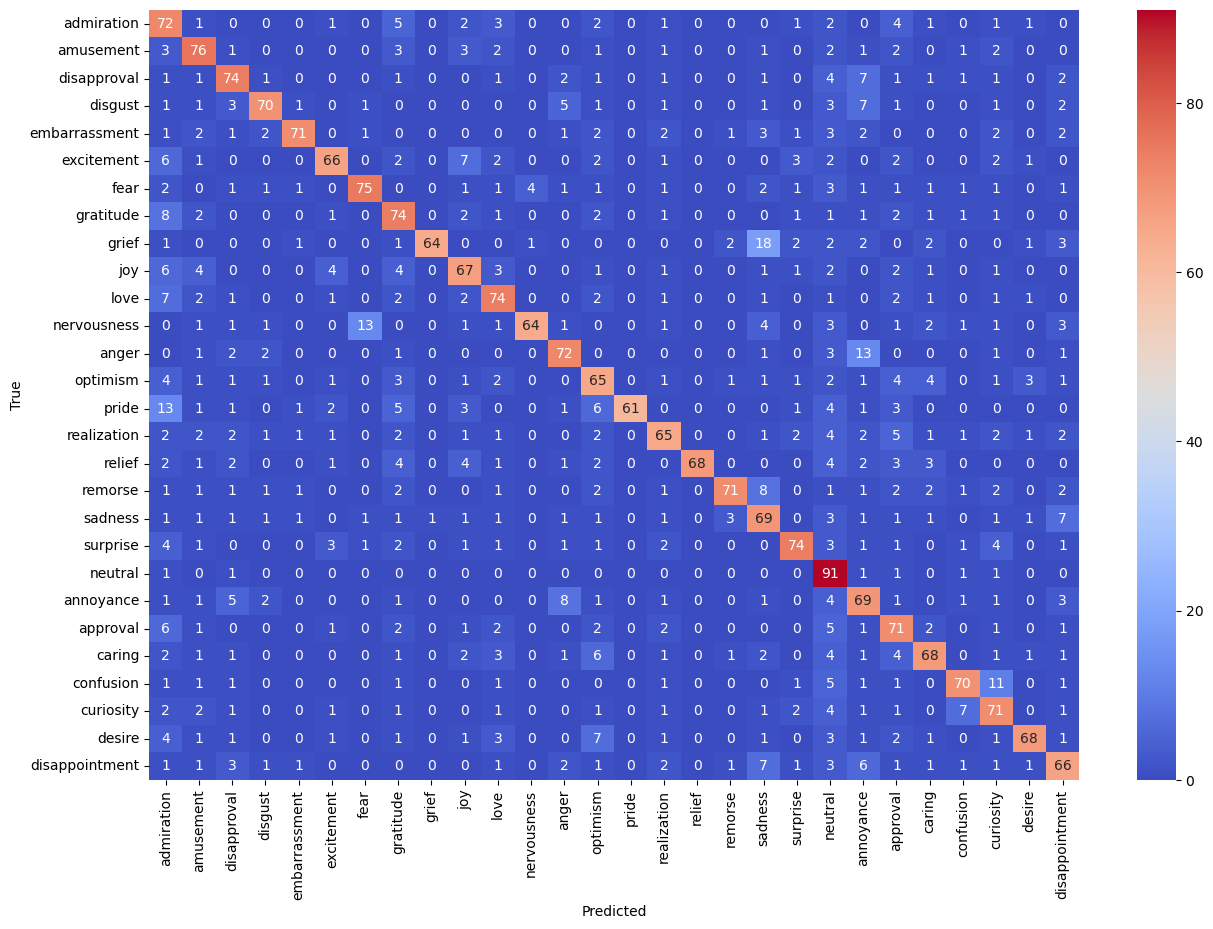

Val confusion matrix


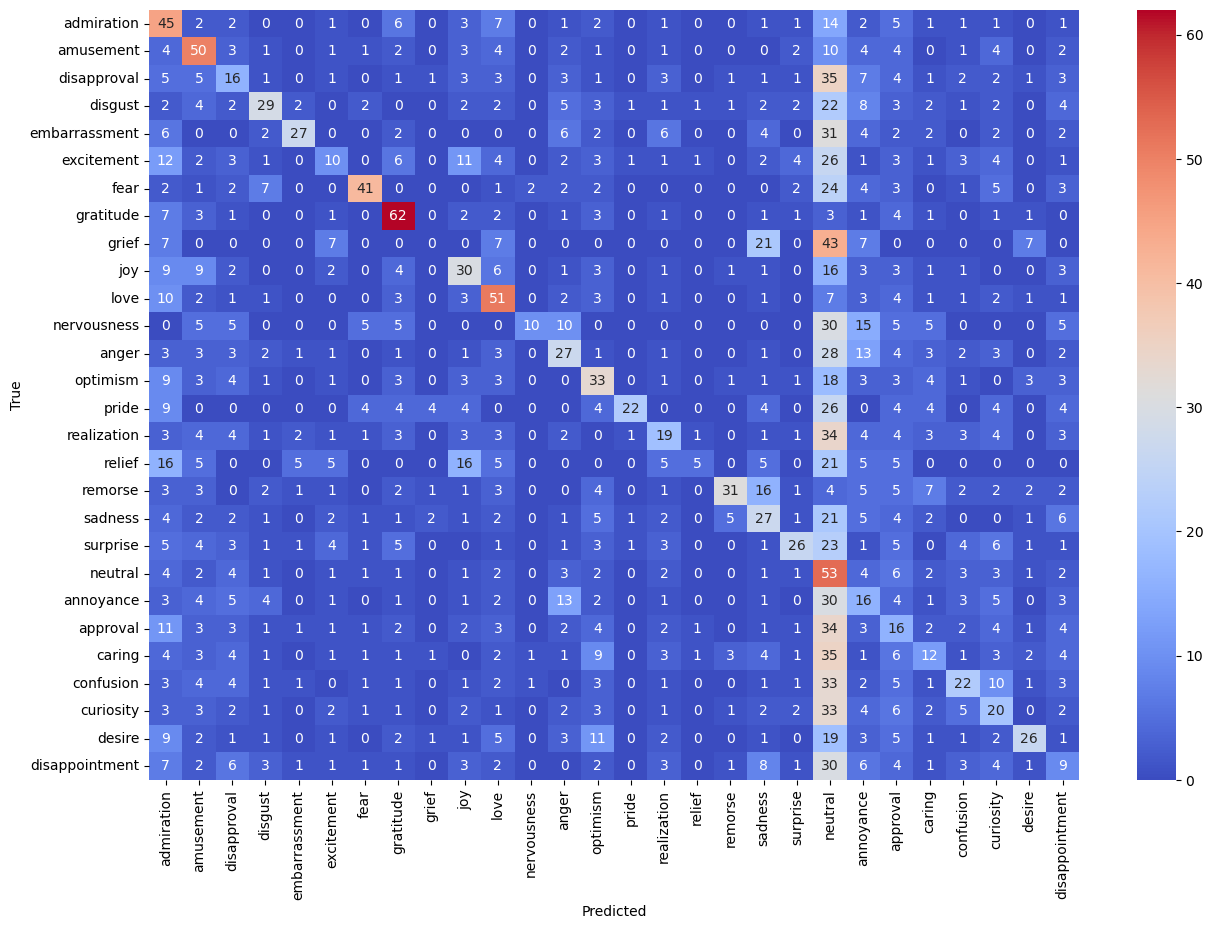

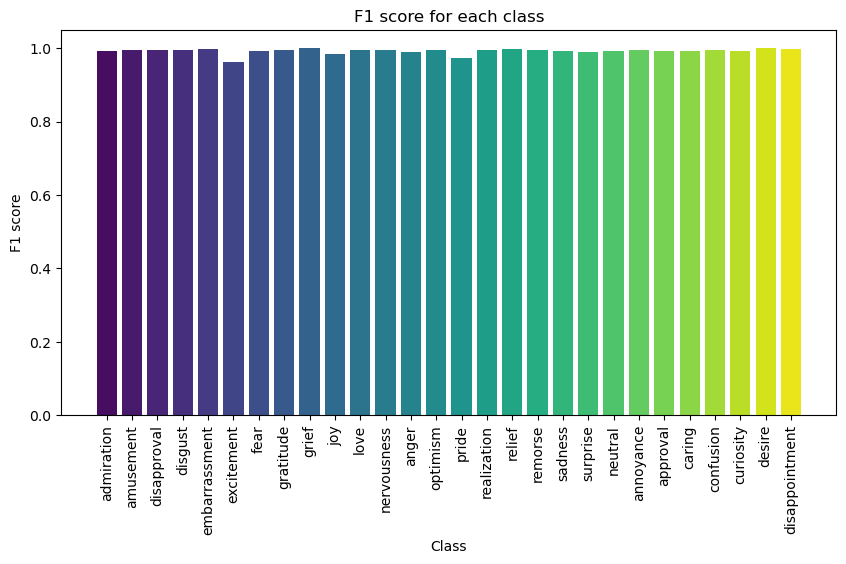

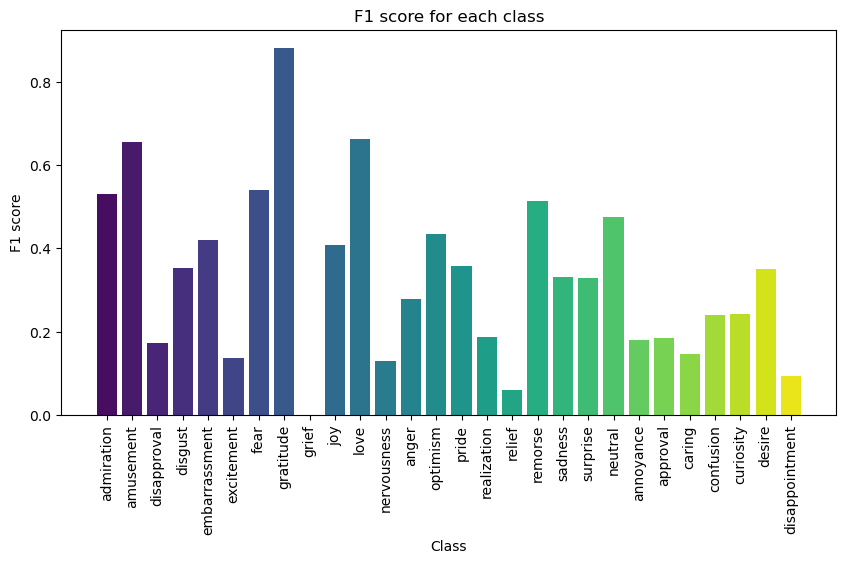

In [8]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer(min_df=10)),
    ('clf', DecisionTreeClassifier())
]))

OVA_clf_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

Attempt also with pmi based feature selection

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.99                0.96                0.98                0.95                4130
amusement                           1.00                0.98                0.99                0.98                2328
disapproval                         1.00                0.97                0.99                0.97                2022
disgust                             1.00                0.97                0.98                0.97                 793
embarrassment                       1.00                0.99                0.99                0.99                 303
excitement                          1.00                0.89                0.94                0.89                 853
fear                                1.00                0.98                0.99                0.98                

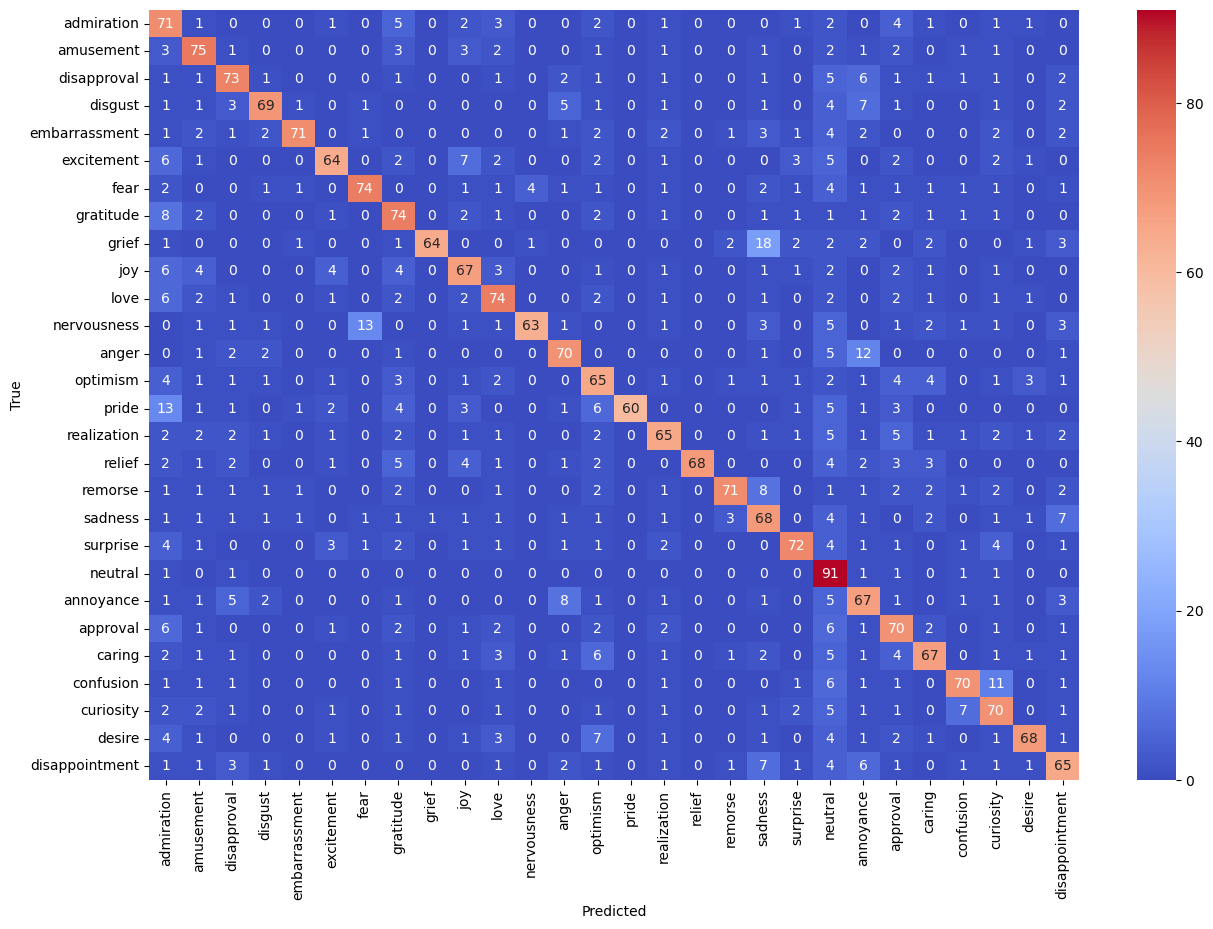

Val confusion matrix


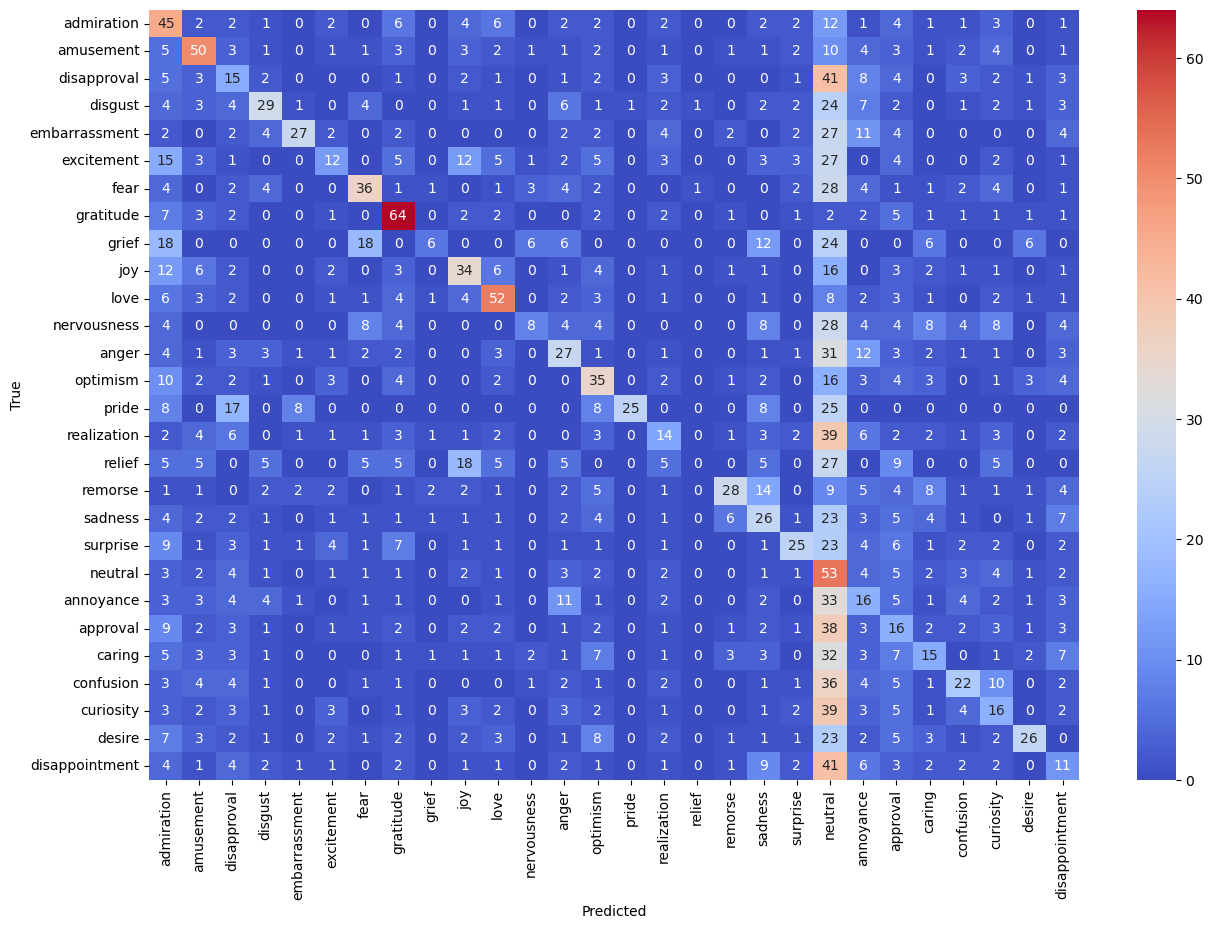

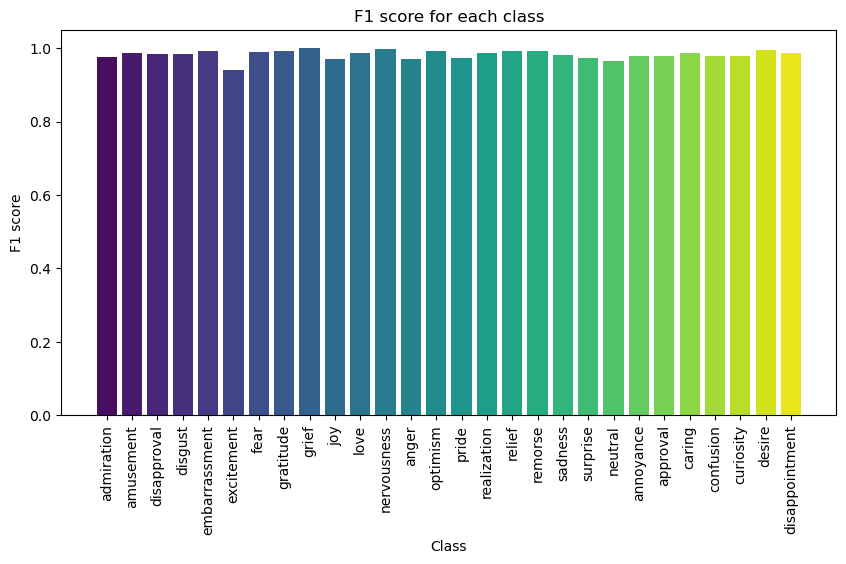

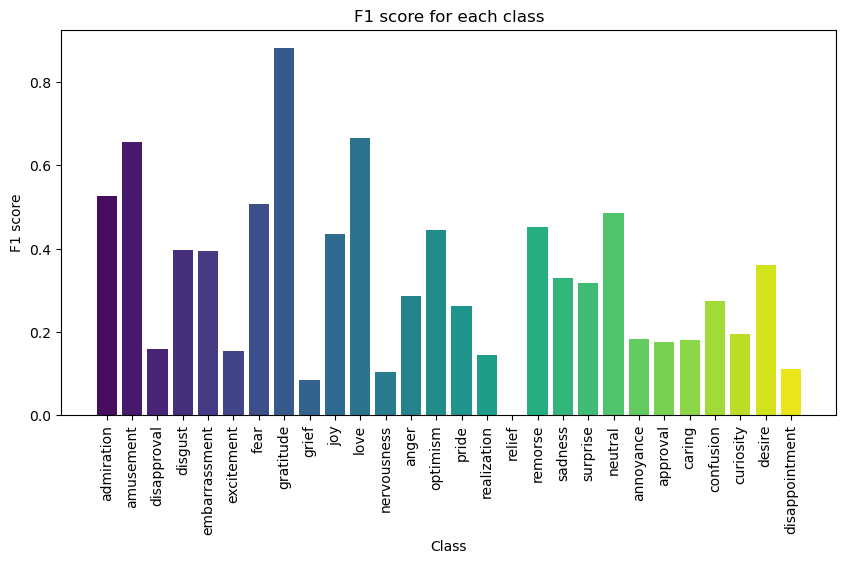

In [9]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('vect', CountVectorizer(min_df=5)),
    ('select', SelectKBest(mutual_info_classif, k=1000)),
    ('tfidf', TfidfTransformer()),
    ('clf', DecisionTreeClassifier())
]))

OVA_clf_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

In [10]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('vect', CountVectorizer()),
    ('select', SelectKBest(mutual_info_classif, k=2000)),
    ('tfidf', TfidfTransformer()),
    ('clf', DecisionTreeClassifier())
]))

OVA_clf_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

### Trying best so far on raw data to check for cleaning usefulness

In [ ]:
# load raw dataset
raw_train_df, raw_val_df, raw_test_df = load_dataset(DatasetEnum.GoEmotions, k_hot_encode=True)

In [ ]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier())
]))

OVA_clf_analysis(raw_train_df, raw_val_df, classifier, TEXT_COLUMN, LABELS)

No relevant changes in original performance

# TFIDF Random forest

In [ ]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(n_jobs=-1))
]))

OVA_clf_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

overfitting wrt the original decision tree approach

In [ ]:
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(n_jobs=-1, min_samples_split=10))
]))

OVA_clf_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

the problem may be uninteresting randomly selected features, increasing the number of features may help

In [ ]:
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(n_jobs=-1, min_samples_split=10, max_features=1000))
]))

OVA_clf_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

In [ ]:
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(n_jobs=-1, min_samples_split=10, max_features=2000))
]))

OVA_clf_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

increasing features again may need comparable time wrt finetuning bert

In [ ]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('vect', CountVectorizer(min_df=5)),
    ('select', SelectKBest(mutual_info_classif, k=2000)),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_jobs=-1, min_samples_split=10))
]))

OVA_clf_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

In [ ]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('vect', CountVectorizer(min_df=3)),
    ('select', SelectKBest(mutual_info_classif, k=5000)),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_jobs=-1, min_samples_split=10))
]))

OVA_clf_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

In [ ]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('vect', CountVectorizer(min_df=3)),
    ('select', SelectKBest(mutual_info_classif, k=500)),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_jobs=-1, min_samples_split=5))
]))

OVA_clf_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

# Saving best models

In [ ]:
CLASSIFIER_PATH = './checkpoints/GoEmotions/'#TODO rerun all and check best
if not os.path.exists(CLASSIFIER_PATH):
    os.makedirs(CLASSIFIER_PATH)
DT_CLASSIFIER_PATH = CLASSIFIER_PATH + 'dt_classifier.pkl'
RF_CLASSIFIER_PATH = CLASSIFIER_PATH + 'rf_classifier.pkl'
RESULTS_PATH = './results/GoEmotions/'

In [ ]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier())
]))

OVA_clf_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

# save classifier
with open(DT_CLASSIFIER_PATH, 'wb') as f:
    pickle.dump(classifier, f)

In [ ]:
# training best random forest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(n_jobs=-1, min_samples_split=10, max_features=2000))
]))

OVA_clf_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

# save classifier
with open(RF_CLASSIFIER_PATH, 'wb') as f:
    pickle.dump(classifier, f)

## Features score (Decision Tree)

In [ ]:
# load best decision tree
with open(DT_CLASSIFIER_PATH, 'rb') as f:
    classifier = pickle.load(f)

In [ ]:
feature_importance = pd.DataFrame(columns=["word", "emotion", "score"])
for emotion, estimator in zip(LABELS, classifier.estimators_):
    score = estimator.named_steps['clf'].feature_importances_
    all_words = estimator.named_steps['tfidf'].get_feature_names_out()
    words = all_words[score > 0]
    score = score[score > 0]
    feature_importance = pd.concat([feature_importance, pd.DataFrame({"word": words, "emotion": emotion, "score": score})], ignore_index=True)

In [ ]:
feature_importance

In [ ]:
# save csv
if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)
feature_importance.to_csv(RESULTS_PATH + 'GoEmotions_dt_features.csv', index=False)

In [ ]:
# word cloud of top 30 features for each class
N_TOP = 30
for label in LABELS:
    print(f'Word cloud for {label}')
    top_data = feature_importance[feature_importance['emotion'] == label].sort_values(by='score', ascending=False).head(N_TOP)
    wc = WordCloud(width=800, height=400, max_words=N_TOP).generate_from_frequencies({row['word']: row['score'] for _, row in top_data.iterrows()})
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

## Features score (Random Forest)

In [ ]:
# load best random forest
with open(RF_CLASSIFIER_PATH, 'rb') as f:
    classifier = pickle.load(f)

In [ ]:
feature_importance = pd.DataFrame(columns=["word", "emotion", "score"])
for emotion, estimator in zip(LABELS, classifier.estimators_):
    score = estimator.named_steps['clf'].feature_importances_
    all_words = estimator.named_steps['tfidf'].get_feature_names_out()
    words = all_words[score > 0]
    score = score[score > 0]
    feature_importance = pd.concat([feature_importance, pd.DataFrame({"word": words, "emotion": emotion, "score": score})], ignore_index=True)

In [ ]:
feature_importance

In [ ]:
# save csv
if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)
feature_importance.to_csv(RESULTS_PATH + 'GoEmotions_rf_features.csv', index=False)

In [ ]:
# word cloud of top 30 features for each class
N_TOP = 30
for label in LABELS:
    print(f'Word cloud for {label}')
    top_data = feature_importance[feature_importance['emotion'] == label].sort_values(by='score', ascending=False).head(N_TOP)
    wc = WordCloud(width=800, height=400, max_words=N_TOP).generate_from_frequencies({row['word']: row['score'] for _, row in top_data.iterrows()})
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Attempt with grouped labels

In [ ]:
GROUPED_DT_FILE = CLASSIFIER_PATH + 'GoEmotions_grouped_dt.pkl'
GROUPED_RF_FILE = CLASSIFIER_PATH + 'GoEmotions_grouped_rt.pkl'

train_df = goemotions_apply_emotion_mapping(train_df)
val_df = goemotions_apply_emotion_mapping(val_df)
test_df = goemotions_apply_emotion_mapping(test_df)
# remove ekman_ prefix from label names
train_df.columns = train_df.columns.str.replace('ekman_', '')
val_df.columns = val_df.columns.str.replace('ekman_', '')
test_df.columns = test_df.columns.str.replace('ekman_', '')
LABELS_GROUPED = list(GOEMOTIONS_EKMAN_MAPPING.keys())
# remove ekman_ prefix from label names
LABELS_GROUPED = [label.replace('ekman_', '') for label in LABELS_GROUPED]

In [ ]:
train_df

In [ ]:
# train decision tree classifier
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier())
]))

OVA_clf_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS_GROUPED)

# save classifier
with open(GROUPED_DT_FILE, 'wb') as f:
    pickle.dump(classifier, f)

In [ ]:
# train random forest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(n_jobs=-1, min_samples_split=10, max_features=2000))
]))

OVA_clf_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS_GROUPED)

# save classifier
with open(GROUPED_RF_FILE, 'wb') as f:
    pickle.dump(classifier, f)

## Features score (Decision Tree)

In [ ]:
# load best random forest
with open(GROUPED_DT_FILE, 'rb') as f:
    classifier = pickle.load(f)

In [ ]:
feature_importance = pd.DataFrame(columns=["word", "emotion", "score"])
for emotion, estimator in zip(LABELS_GROUPED, classifier.estimators_):
    score = estimator.named_steps['clf'].feature_importances_
    all_words = estimator.named_steps['tfidf'].get_feature_names_out()
    words = all_words[score > 0]
    score = score[score > 0]
    feature_importance = pd.concat([feature_importance, pd.DataFrame({"word": words, "emotion": emotion, "score": score})], ignore_index=True)

In [ ]:
feature_importance

In [ ]:
# save csv
if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)
feature_importance.to_csv(RESULTS_PATH + 'GoEmotions_grouped_dt_features.csv', index=False)

In [ ]:
# word cloud of top 30 features for each class
N_TOP = 30
for label in LABELS_GROUPED:
    print(f'Word cloud for {label}')
    top_data = feature_importance[feature_importance['emotion'] == label].sort_values(by='score', ascending=False).head(N_TOP)
    wc = WordCloud(width=800, height=400, max_words=N_TOP).generate_from_frequencies({row['word']: row['score'] for _, row in top_data.iterrows()})
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

## Features score (Random Forest)

In [ ]:
# load best random forest
with open(GROUPED_RF_FILE, 'rb') as f:
    classifier = pickle.load(f)

In [ ]:
feature_importance = pd.DataFrame(columns=["word", "emotion", "score"])
for emotion, estimator in zip(LABELS_GROUPED, classifier.estimators_):
    score = estimator.named_steps['clf'].feature_importances_
    all_words = estimator.named_steps['tfidf'].get_feature_names_out()
    words = all_words[score > 0]
    score = score[score > 0]
    feature_importance = pd.concat([feature_importance, pd.DataFrame({"word": words, "emotion": emotion, "score": score})], ignore_index=True)

In [ ]:
feature_importance

In [ ]:
# save csv
if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)
feature_importance.to_csv(RESULTS_PATH + 'GoEmotions_grouped_rf_features.csv', index=False)

In [ ]:
# word cloud of top 30 features for each class
N_TOP = 30
for label in LABELS_GROUPED:
    print(f'Word cloud for {label}')
    top_data = feature_importance[feature_importance['emotion'] == label].sort_values(by='score', ascending=False).head(N_TOP)
    wc = WordCloud(width=800, height=400, max_words=N_TOP).generate_from_frequencies({row['word']: row['score'] for _, row in top_data.iterrows()})
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

## Mapping Analysis (Decision Tree)

In [ ]:
# group labels
LABELS = test_df.columns[1:]
grouped_test_df = goemotions_apply_emotion_mapping(test_df)
GROUPED_LABELS = grouped_test_df.columns[1:].tolist()
# keep only records in grouped_test_df
test_df = test_df.loc[grouped_test_df.index]
# prediction on test
predictions_test = classifier.predict(grouped_test_df[TEXT_COLUMN])
# plot confusion matrix
print("Ekman Mapping")
plot_multilabel_confusion_heatmap(test_df[LABELS].values, predictions_test, LABELS, GROUPED_LABELS, normalize=True, transpose=False)
# mapping wrt twitter emotions
_, _, test_df = load_dataset(DatasetEnum.TwitterDataCleaned)
TWITTER_LABELS = test_df.columns[1:].tolist()
predictions_test = classifier.predict(test_df[TEXT_COLUMN])
print("Parrott Mapping")
plot_multilabel_confusion_heatmap(test_df[TWITTER_LABELS].values, predictions_test, TWITTER_LABELS, LABELS, normalize=True, transpose=False)

In [ ]:
# load best model
with open(DT_CLASSIFIER_PATH, 'rb') as f:
    classifier = pickle.load(f)
# load dataset
_, _, test_df = load_dataset(DATASET)
test_df = clean_df(test_df, TEXT_COLUMN, TEXT_COLUMN)
# group labels
LABELS = test_df.columns[1:]
grouped_test_df = goemotions_apply_emotion_mapping(test_df)
GROUPED_LABELS = grouped_test_df.columns[1:].tolist()
# keep only records in grouped_test_df
test_df = test_df.loc[grouped_test_df.index]
# prediction on test
predictions_test = classifier.predict(grouped_test_df[TEXT_COLUMN])
# plot confusion matrix
print("Ekman Mapping")
plot_multilabel_confusion_heatmap(grouped_test_df[GROUPED_LABELS].values, predictions_test, GROUPED_LABELS, LABELS, normalize=True, transpose=False)
# mapping wrt twitter emotions
_, _, test_df = load_dataset(DatasetEnum.TwitterDataCleaned)
test_df = clean_df(test_df, TEXT_COLUMN, TEXT_COLUMN)
TWITTER_LABELS = test_df.columns[1:].tolist()
predictions_test = classifier.predict(test_df[TEXT_COLUMN])
print("Parrott Mapping")
plot_multilabel_confusion_heatmap(test_df[TWITTER_LABELS].values, predictions_test, TWITTER_LABELS, LABELS, normalize=True, transpose=False)

## Mapping Analysis (Random Forest)

In [ ]:
# load best model
with open(RF_CLASSIFIER_PATH, 'rb') as f:
    classifier = pickle.load(f)
# load dataset
_, _, test_df = load_dataset(DATASET)
test_df = clean_df(test_df, TEXT_COLUMN, TEXT_COLUMN)
# group labels
LABELS = test_df.columns[1:]
grouped_test_df = goemotions_apply_emotion_mapping(test_df)
GROUPED_LABELS = grouped_test_df.columns[1:].tolist()
# keep only records in grouped_test_df
test_df = test_df.loc[grouped_test_df.index]
# prediction on test
predictions_test = classifier.predict(grouped_test_df[TEXT_COLUMN])
# plot confusion matrix
print("Ekman Mapping")
plot_multilabel_confusion_heatmap(grouped_test_df[GROUPED_LABELS].values, predictions_test, GROUPED_LABELS, LABELS, normalize=True, transpose=False)
# mapping wrt twitter emotions
_, _, test_df = load_dataset(DatasetEnum.TwitterDataCleaned)
test_df = clean_df(test_df, TEXT_COLUMN, TEXT_COLUMN)
TWITTER_LABELS = test_df.columns[1:].tolist()
predictions_test = classifier.predict(test_df[TEXT_COLUMN])
print("Parrott Mapping")
plot_multilabel_confusion_heatmap(test_df[TWITTER_LABELS].values, predictions_test, TWITTER_LABELS, LABELS, normalize=True, transpose=False)